#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving reinforcement learning problems. The basic tasks for the homework will require to implement some extensions to the code that you have seen in the Lab. More advanced tasks will require to train and test your learning agent on a different environment. Given the higher computational complexity of RL, in this homework you don’t need to tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged to play with model hyperparameters in order to find a satisfactory configuration.


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.

As an example of more advanced libraries that can be used to implement deep RL agents, you can check this website:

https://stable-baselines.readthedocs.io/en/master/



## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). Given the dynamical nature of RL problems, you can explore more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: extend the notebook used in Lab 07, in order to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Try to tune the model hyperparameters or tweak the reward function in order to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).
*	3 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). This will require to change the “observation_space”.
*	3 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms:
https://gym.openai.com/envs 



## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

# **Definition of Libraries**

In [ ]:
!pip install gym
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 htt

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# **Implementation of Replay Memory**

$e_t=(s_t,a_t,r_t,s_t+1)$

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (5, 5, 5, 5)]


**Implementation of Policy Network**

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 256),
                nn.Tanh(),
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

# **Exploration Policies**



$\epsilon$-greedy policy

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.3
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.00264659 -0.0652016 ]


Softmax Policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)
        

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
    print(net_out.shape)
    print(softmax_out)
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

torch.Size([2])
[0.493973 0.506027]
ACTION: 1
Q-VALUES: [-0.06682539 -0.04271623]


**Exploration Profile**

We are going to tune the following hyperparameters for obtaining higher values of accuracy in the gym environment. We can model the exploration behaviour of a player in an environment. In this case, we model using the exponentially decreasing exploration.

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

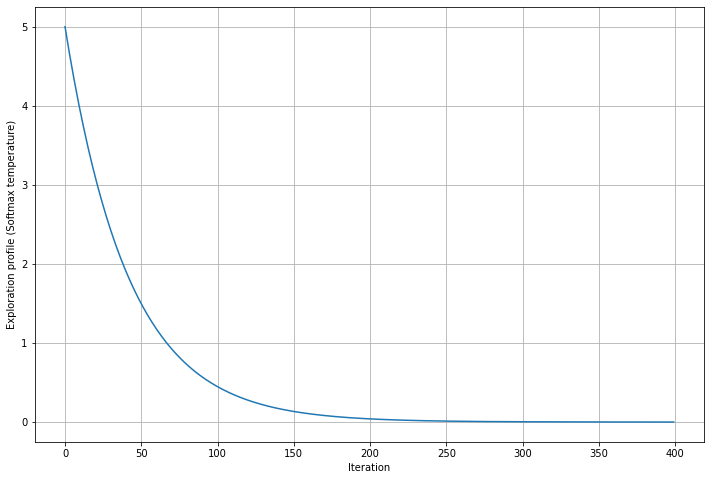

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 400
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

----
# **GYM Environment CartPole-v1**




In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


We define a Random Agent so random decisions

In [ ]:
# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: 28.0
EPISODE 2 - FINAL SCORE: 22.0
EPISODE 3 - FINAL SCORE: 17.0
EPISODE 4 - FINAL SCORE: 24.0
EPISODE 5 - FINAL SCORE: 22.0
EPISODE 6 - FINAL SCORE: 14.0
EPISODE 7 - FINAL SCORE: 41.0
EPISODE 8 - FINAL SCORE: 32.0
EPISODE 9 - FINAL SCORE: 21.0
EPISODE 10 - FINAL SCORE: 12.0


In order to see the videos, we call $show videos$ function defined at the beginning of the notebook

In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.3.1300.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.1300.video000009.mp4


---
# **Network Update**





Now we use the DQN network in order to choose the actions w.r.t. Q-values.


**PARAMETERS**

In [ ]:
!pip install optuna
import optuna

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2 # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 1   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

Initialization of Replay Memory

**Update Function**

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()


Training loop

In [ ]:
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
def objectivefunction(trial):# This is for creating the output video in Colab, not required outside Colab
  

  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


  ## Number of batches
  batch_size = trial.suggest_categorical('batch_size',[2**i for i in range(6,11)])
  ## Type of policy
  policyFunction = trial.suggest_categorical('policy', ['Softmax', 'Epsilon'])
  ## Gamma value
  gamma = trial.suggest_uniform('gamma', 0.5, 1.0)
  ## bad state penalty value
  bad_state_penalty = trial.suggest_int('Penalty bad state', 0, 10)
  ## net_update_steps value
  net_update_steps = trial.suggest_int('net_update_steps', 1, 100)

  ### Initialize the replay memory
  replay_mem = ReplayMemory(replay_memory_capacity)    

  ### Initialize the policy network
  policy_net = DQN(state_space_dim, action_space_dim)

  ### Initialize the target network with the same weights of the policy network
  target_net = DQN(state_space_dim, action_space_dim)
  target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  ### Initialize the optimizer
  optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network


  ### Initialize the loss function (Huber loss)
  loss_fn = nn.SmoothL1Loss()


  ### Create environment
  env = gym.make('CartPole-v1') # Initialize the Gym environment
  env.seed(0) # Set a random seed for the environment (reproducible results)
  episodeScore = []

  for episode_num, tau in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False

      # Go on until the pole falls off - (foreach frame)
      while not done and score < 490:

        # Choose the action following the policy
        if (policyFunction == 'Epsilon'):
          action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=0.2)
        else:
          action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        env.render()

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      if episode_num % target_net_update_steps == 0:
          print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
      episodeScore.append(score)

  env.close()
  return np.mean(episodeScore)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objectivefunction, n_trials=75)

[I 2021-01-14 23:37:20,198] A new study created in memory with name: no-name-ef29d979-caa1-473b-9214-552d2b53e4a7


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:39:11,638] Trial 0 finished with value: 71.3425 and parameters: {'learning_rate': 0.0003686973839319652, 'batch_size': 128, 'policy': 'Softmax', 'gamma': 0.9400520161989008, 'Penalty bad state': 3, 'net_update_steps': 5}. Best is trial 0 with value: 71.3425.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:41:06,630] Trial 1 finished with value: 76.3075 and parameters: {'learning_rate': 2.9990632066211317e-05, 'batch_size': 128, 'policy': 'Epsilon', 'gamma': 0.9631769727657573, 'Penalty bad state': 6, 'net_update_steps': 86}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:41:47,528] Trial 2 finished with value: 32.13 and parameters: {'learning_rate': 0.0023236517912379353, 'batch_size': 64, 'policy': 'Epsilon', 'gamma': 0.5505970418771587, 'Penalty bad state': 9, 'net_update_steps': 45}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:45:47,724] Trial 3 finished with value: 48.785 and parameters: {'learning_rate': 0.0021697038686420912, 'batch_size': 1024, 'policy': 'Softmax', 'gamma': 0.798046728508233, 'Penalty bad state': 3, 'net_update_steps': 64}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:46:08,040] Trial 4 finished with value: 14.2725 and parameters: {'learning_rate': 0.0003421688400393627, 'batch_size': 128, 'policy': 'Epsilon', 'gamma': 0.583727335092042, 'Penalty bad state': 7, 'net_update_steps': 21}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:47:26,888] Trial 5 finished with value: 60.555 and parameters: {'learning_rate': 6.050846301377637e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.7906275115778532, 'Penalty bad state': 2, 'net_update_steps': 49}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:48:45,159] Trial 6 finished with value: 60.27 and parameters: {'learning_rate': 8.510900269295603e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.8846558367820203, 'Penalty bad state': 5, 'net_update_steps': 63}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:50:14,675] Trial 7 finished with value: 46.27 and parameters: {'learning_rate': 9.402863911227158e-05, 'batch_size': 256, 'policy': 'Epsilon', 'gamma': 0.8999476192552452, 'Penalty bad state': 0, 'net_update_steps': 42}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:51:11,426] Trial 8 finished with value: 29.165 and parameters: {'learning_rate': 4.830238438153989e-05, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.7318951500898119, 'Penalty bad state': 8, 'net_update_steps': 39}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:51:28,351] Trial 9 finished with value: 12.3625 and parameters: {'learning_rate': 0.00014933283299938896, 'batch_size': 128, 'policy': 'Epsilon', 'gamma': 0.7233408361469481, 'Penalty bad state': 8, 'net_update_steps': 65}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:53:57,837] Trial 10 finished with value: 46.7725 and parameters: {'learning_rate': 1.0078972145459523e-05, 'batch_size': 512, 'policy': 'Epsilon', 'gamma': 0.9930507352562273, 'Penalty bad state': 6, 'net_update_steps': 96}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:55:34,895] Trial 11 finished with value: 63.0525 and parameters: {'learning_rate': 0.0007758292839774637, 'batch_size': 128, 'policy': 'Softmax', 'gamma': 0.9708307554955083, 'Penalty bad state': 3, 'net_update_steps': 1}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:57:06,372] Trial 12 finished with value: 59.505 and parameters: {'learning_rate': 1.024066542776175e-05, 'batch_size': 128, 'policy': 'Softmax', 'gamma': 0.9257885851873413, 'Penalty bad state': 4, 'net_update_steps': 99}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:58:30,319] Trial 13 finished with value: 57.505 and parameters: {'learning_rate': 0.0076257824365627315, 'batch_size': 128, 'policy': 'Epsilon', 'gamma': 0.9969728093156155, 'Penalty bad state': 0, 'net_update_steps': 84}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-14 23:59:24,428] Trial 14 finished with value: 19.8075 and parameters: {'learning_rate': 3.0155887988285013e-05, 'batch_size': 512, 'policy': 'Epsilon', 'gamma': 0.838556573237542, 'Penalty bad state': 5, 'net_update_steps': 4}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:00:13,547] Trial 15 finished with value: 32.6525 and parameters: {'learning_rate': 0.0005886994949970152, 'batch_size': 128, 'policy': 'Softmax', 'gamma': 0.6536786293170094, 'Penalty bad state': 2, 'net_update_steps': 21}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:03:17,024] Trial 16 finished with value: 38.58 and parameters: {'learning_rate': 0.00023009678370562267, 'batch_size': 1024, 'policy': 'Epsilon', 'gamma': 0.9464012901195441, 'Penalty bad state': 10, 'net_update_steps': 83}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:04:11,124] Trial 17 finished with value: 35.8325 and parameters: {'learning_rate': 1.8595758547406295e-05, 'batch_size': 128, 'policy': 'Softmax', 'gamma': 0.8618496982430092, 'Penalty bad state': 6, 'net_update_steps': 25}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:05:30,244] Trial 18 finished with value: 53.885 and parameters: {'learning_rate': 0.0017814605780542693, 'batch_size': 128, 'policy': 'Epsilon', 'gamma': 0.9999988264305991, 'Penalty bad state': 2, 'net_update_steps': 80}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:07:46,052] Trial 19 finished with value: 67.6525 and parameters: {'learning_rate': 0.0008326576453528342, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9362583924217914, 'Penalty bad state': 4, 'net_update_steps': 10}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:10:46,110] Trial 20 finished with value: 60.25 and parameters: {'learning_rate': 0.005655167282721305, 'batch_size': 512, 'policy': 'Softmax', 'gamma': 0.8118266393769629, 'Penalty bad state': 1, 'net_update_steps': 32}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:12:53,372] Trial 21 finished with value: 63.905 and parameters: {'learning_rate': 0.0009251427777871768, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9287632525164569, 'Penalty bad state': 4, 'net_update_steps': 9}. Best is trial 1 with value: 76.3075.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:15:27,300] Trial 22 finished with value: 77.34 and parameters: {'learning_rate': 0.00038062221533835186, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9533280699211506, 'Penalty bad state': 4, 'net_update_steps': 13}. Best is trial 22 with value: 77.34.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:18:26,214] Trial 23 finished with value: 90.9475 and parameters: {'learning_rate': 0.0003136258842717627, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9662429941986911, 'Penalty bad state': 6, 'net_update_steps': 8}. Best is trial 23 with value: 90.9475.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:21:53,544] Trial 24 finished with value: 105.85 and parameters: {'learning_rate': 0.00019488108029635156, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9982239290493793, 'Penalty bad state': 6, 'net_update_steps': 17}. Best is trial 24 with value: 105.85.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:23:11,362] Trial 25 finished with value: 40.195 and parameters: {'learning_rate': 0.0001774927555207957, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.8770218737942044, 'Penalty bad state': 7, 'net_update_steps': 14}. Best is trial 24 with value: 105.85.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:26:17,105] Trial 26 finished with value: 94.495 and parameters: {'learning_rate': 0.0004408035970477046, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9941080206982532, 'Penalty bad state': 7, 'net_update_steps': 33}. Best is trial 24 with value: 105.85.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:29:47,512] Trial 27 finished with value: 106.745 and parameters: {'learning_rate': 0.0001407198318775367, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.992171267151422, 'Penalty bad state': 7, 'net_update_steps': 32}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:30:18,154] Trial 28 finished with value: 16.91 and parameters: {'learning_rate': 0.00012669836243530582, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.6858990509499248, 'Penalty bad state': 8, 'net_update_steps': 32}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:30:48,776] Trial 29 finished with value: 16.8775 and parameters: {'learning_rate': 0.0004947644914311032, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.5016117889858944, 'Penalty bad state': 10, 'net_update_steps': 56}. Best is trial 27 with value: 106.745.


Updating target network...



Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:33:39,843] Trial 30 finished with value: 86.925 and parameters: {'learning_rate': 0.00023672012856563733, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.999647704517995, 'Penalty bad state': 7, 'net_update_steps': 32}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:36:37,832] Trial 31 finished with value: 90.255 and parameters: {'learning_rate': 0.00031963865036995637, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9789748538884436, 'Penalty bad state': 6, 'net_update_steps': 25}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:38:56,013] Trial 32 finished with value: 70.3775 and parameters: {'learning_rate': 0.00018300983921334474, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9146590144243254, 'Penalty bad state': 7, 'net_update_steps': 18}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:41:08,446] Trial 33 finished with value: 66.9225 and parameters: {'learning_rate': 0.001239872944811267, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9661807841427603, 'Penalty bad state': 9, 'net_update_steps': 37}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:44:23,326] Trial 34 finished with value: 98.52 and parameters: {'learning_rate': 0.00010904413051233572, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9893542050180629, 'Penalty bad state': 6, 'net_update_steps': 27}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:51:06,918] Trial 35 finished with value: 81.3425 and parameters: {'learning_rate': 5.394874188945361e-05, 'batch_size': 1024, 'policy': 'Softmax', 'gamma': 0.9987631688338842, 'Penalty bad state': 9, 'net_update_steps': 27}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:52:19,922] Trial 36 finished with value: 37.2125 and parameters: {'learning_rate': 9.135019514460577e-05, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.8480797463428942, 'Penalty bad state': 5, 'net_update_steps': 44}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:53:25,300] Trial 37 finished with value: 49.9175 and parameters: {'learning_rate': 0.00012099140454407446, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9078365375611241, 'Penalty bad state': 7, 'net_update_steps': 53}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:55:44,494] Trial 38 finished with value: 70.205 and parameters: {'learning_rate': 3.5417718218822445e-05, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9489037718270505, 'Penalty bad state': 8, 'net_update_steps': 20}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:57:36,747] Trial 39 finished with value: 57.1275 and parameters: {'learning_rate': 6.637194519047098e-05, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9013179955445958, 'Penalty bad state': 6, 'net_update_steps': 36}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 00:58:44,880] Trial 40 finished with value: 34.51 and parameters: {'learning_rate': 0.0004993738835749135, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.6075435820050792, 'Penalty bad state': 7, 'net_update_steps': 48}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:01:15,587] Trial 41 finished with value: 75.3325 and parameters: {'learning_rate': 0.00024767860648671435, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.972803343943146, 'Penalty bad state': 6, 'net_update_steps': 7}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:04:10,911] Trial 42 finished with value: 87.445 and parameters: {'learning_rate': 0.0003635148221473754, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9801356549026605, 'Penalty bad state': 5, 'net_update_steps': 17}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:06:58,883] Trial 43 finished with value: 82.36 and parameters: {'learning_rate': 0.00011078987214960133, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.957824772741354, 'Penalty bad state': 6, 'net_update_steps': 27}. Best is trial 27 with value: 106.745.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:10:49,524] Trial 44 finished with value: 107.5875 and parameters: {'learning_rate': 7.560996930800027e-05, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.997309398654384, 'Penalty bad state': 8, 'net_update_steps': 29}. Best is trial 44 with value: 107.5875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:13:24,951] Trial 45 finished with value: 106.9875 and parameters: {'learning_rate': 7.03157910504132e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9906791497911996, 'Penalty bad state': 9, 'net_update_steps': 41}. Best is trial 44 with value: 107.5875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:14:01,093] Trial 46 finished with value: 24.9475 and parameters: {'learning_rate': 7.422372595893824e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.8904275394171174, 'Penalty bad state': 9, 'net_update_steps': 43}. Best is trial 44 with value: 107.5875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:15:33,542] Trial 47 finished with value: 63.6325 and parameters: {'learning_rate': 4.161445271039586e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.930195302636375, 'Penalty bad state': 8, 'net_update_steps': 40}. Best is trial 44 with value: 107.5875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:18:51,222] Trial 48 finished with value: 134.7875 and parameters: {'learning_rate': 1.643463461954604e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9845717474595839, 'Penalty bad state': 9, 'net_update_steps': 28}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:20:52,877] Trial 49 finished with value: 76.9675 and parameters: {'learning_rate': 2.019370447715238e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9996538581004903, 'Penalty bad state': 9, 'net_update_steps': 56}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:22:27,266] Trial 50 finished with value: 62.3 and parameters: {'learning_rate': 2.623763939829519e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9432946619507896, 'Penalty bad state': 10, 'net_update_steps': 24}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:24:15,593] Trial 51 finished with value: 70.98 and parameters: {'learning_rate': 0.0001692675022915963, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9864223423319392, 'Penalty bad state': 8, 'net_update_steps': 29}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:26:15,501] Trial 52 finished with value: 79.7525 and parameters: {'learning_rate': 1.6794539743743435e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9715382963596474, 'Penalty bad state': 9, 'net_update_steps': 39}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:27:49,362] Trial 53 finished with value: 65.175 and parameters: {'learning_rate': 8.088722428790219e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9844785318574466, 'Penalty bad state': 8, 'net_update_steps': 22}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:29:24,827] Trial 54 finished with value: 19.6775 and parameters: {'learning_rate': 1.4116967289053751e-05, 'batch_size': 1024, 'policy': 'Softmax', 'gamma': 0.7735717249617811, 'Penalty bad state': 10, 'net_update_steps': 15}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:32:02,032] Trial 55 finished with value: 51.1975 and parameters: {'learning_rate': 5.0980215318486886e-05, 'batch_size': 512, 'policy': 'Softmax', 'gamma': 0.9260843288855126, 'Penalty bad state': 9, 'net_update_steps': 35}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:34:30,325] Trial 56 finished with value: 113.125 and parameters: {'learning_rate': 0.00010045630830665054, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9535456556882617, 'Penalty bad state': 8, 'net_update_steps': 29}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:35:22,476] Trial 57 finished with value: 41.3575 and parameters: {'learning_rate': 6.0430412467590935e-05, 'batch_size': 64, 'policy': 'Epsilon', 'gamma': 0.9527094419672887, 'Penalty bad state': 8, 'net_update_steps': 1}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:35:48,819] Trial 58 finished with value: 20.575 and parameters: {'learning_rate': 0.00013963024359351194, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.8701703050071536, 'Penalty bad state': 8, 'net_update_steps': 47}. Best is trial 48 with value: 134.7875.


Updating target network...



Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:36:50,406] Trial 59 finished with value: 46.485 and parameters: {'learning_rate': 3.059624600524467e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9168646653910466, 'Penalty bad state': 9, 'net_update_steps': 30}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:37:17,515] Trial 60 finished with value: 21.3275 and parameters: {'learning_rate': 0.0002060902373798625, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.8262793486070014, 'Penalty bad state': 7, 'net_update_steps': 22}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:38:59,143] Trial 61 finished with value: 77.1325 and parameters: {'learning_rate': 9.744881302105581e-05, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9984234462416851, 'Penalty bad state': 7, 'net_update_steps': 28}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:42:43,924] Trial 62 finished with value: 73.5175 and parameters: {'learning_rate': 0.00013752922497282108, 'batch_size': 512, 'policy': 'Softmax', 'gamma': 0.9630335586099431, 'Penalty bad state': 6, 'net_update_steps': 41}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:44:47,096] Trial 63 finished with value: 93.6225 and parameters: {'learning_rate': 0.00010343026700483166, 'batch_size': 64, 'policy': 'Softmax', 'gamma': 0.9841714586885703, 'Penalty bad state': 8, 'net_update_steps': 12}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:51:00,638] Trial 64 finished with value: 73.8525 and parameters: {'learning_rate': 4.027326065897486e-05, 'batch_size': 1024, 'policy': 'Softmax', 'gamma': 0.9989826425521569, 'Penalty bad state': 10, 'net_update_steps': 34}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:54:35,168] Trial 65 finished with value: 86.67 and parameters: {'learning_rate': 0.00025856124485064847, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.940190061131986, 'Penalty bad state': 5, 'net_update_steps': 18}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:57:01,515] Trial 66 finished with value: 73.155 and parameters: {'learning_rate': 7.41487155787707e-05, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9618725829692034, 'Penalty bad state': 7, 'net_update_steps': 31}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 01:58:05,122] Trial 67 finished with value: 50.5725 and parameters: {'learning_rate': 0.00014396184053681098, 'batch_size': 64, 'policy': 'Epsilon', 'gamma': 0.9811351968800823, 'Penalty bad state': 8, 'net_update_steps': 37}. Best is trial 48 with value: 134.7875.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:03:36,478] Trial 68 finished with value: 164.35 and parameters: {'learning_rate': 0.00016393431203613848, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9997975431228965, 'Penalty bad state': 6, 'net_update_steps': 25}. Best is trial 68 with value: 164.35.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:05:05,759] Trial 69 finished with value: 57.4225 and parameters: {'learning_rate': 0.00028289381397700184, 'batch_size': 128, 'policy': 'Softmax', 'gamma': 0.9406444157305158, 'Penalty bad state': 9, 'net_update_steps': 23}. Best is trial 68 with value: 164.35.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:07:41,708] Trial 70 finished with value: 75.9825 and parameters: {'learning_rate': 0.00018799258006471978, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9671241519669814, 'Penalty bad state': 7, 'net_update_steps': 45}. Best is trial 68 with value: 164.35.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:10:15,408] Trial 71 finished with value: 76.705 and parameters: {'learning_rate': 0.0001122377621789585, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9994649286270634, 'Penalty bad state': 6, 'net_update_steps': 26}. Best is trial 68 with value: 164.35.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:13:55,203] Trial 72 finished with value: 110.1525 and parameters: {'learning_rate': 0.0001634144493600246, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9774518697132277, 'Penalty bad state': 6, 'net_update_steps': 19}. Best is trial 68 with value: 164.35.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:16:49,871] Trial 73 finished with value: 87.76 and parameters: {'learning_rate': 0.00017063862178926794, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9544204841766872, 'Penalty bad state': 5, 'net_update_steps': 16}. Best is trial 68 with value: 164.35.


Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

[I 2021-01-15 02:19:13,431] Trial 74 finished with value: 72.685 and parameters: {'learning_rate': 0.00022277578091052842, 'batch_size': 256, 'policy': 'Softmax', 'gamma': 0.9753700163834549, 'Penalty bad state': 7, 'net_update_steps': 20}. Best is trial 68 with value: 164.35.


Obtaining best params

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
study.best_params

{'Penalty bad state': 6,
 'batch_size': 256,
 'gamma': 0.9997975431228965,
 'learning_rate': 0.00016393431203613848,
 'net_update_steps': 25,
 'policy': 'Softmax'}

In [ ]:
trial = study.best_trial
best_params = trial.params


In [ ]:
learning_rate = best_params['learning_rate']

## Number of batches
batch_size = best_params['batch_size']
## Type of policy
policyFunction = best_params['policy']
## Gamma value
gamma = best_params['gamma']
## bad state penalty value
bad_state_penalty = best_params['Penalty bad state']
## net_update_steps value
net_update_steps = best_params['net_update_steps']

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network


### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()


### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
episodeScore = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off - (foreach frame)
    while not done and score < 490:

      # Choose the action following the policy
      if (policyFunction == 'Epsilon'):
        action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=0.2)
      else:
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    episodeScore.append(score)

env.close()

Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
Updating target network...
U

**FINAL TEST**

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.5.1300.video000000.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000001.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000002.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000003.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000004.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000005.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000006.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000007.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000008.mp4



SHOWING VIDEO video/openaigym.video.5.1300.video000009.mp4


----
# **CartPole analyzing pixels of the screen**

We have to insert convolutional layers for states

In [ ]:
!pip install gym
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory








In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.8 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

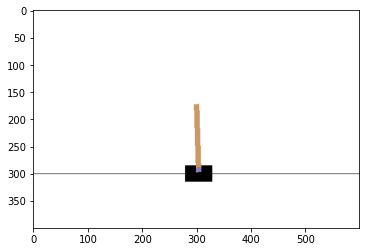

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

env.reset()
screenGame = env.render(mode = 'rgb_array')

# Thank to this tool we can see screen of the env
plt.figure()

plt.imshow(screenGame) 
plt.show()

# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

Images are $400\times600$ RGB pixels. We have to take into account when we implement the Convolutional Network for the policy.

Now we have a system which has to extract $4$ features (position, velocity, angle and velocity of angle) in order to decide two possible movements.

In this implementation input image has to be elaborated in order to understand when the cart pole has to go right or left.


In [ ]:
class DQNCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.ConvGroup = nn.Sequential(
            nn.Conv2d(in_channels = 4, out_channels = 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(in_features = 64*7*7, out_features = 512),
            nn.Tanh(),
            nn.Linear(in_features = 512, out_features = 512),
            nn.Tanh(),
            nn.Linear(in_features = 512, out_features = 2)
        )

    def forward(self, x):
        x =  self.ConvGroup(x)
        x = self.flatten(x)
        return self.linear(x)



testNetwork = DQNCNN().to(device)
testInput = torch.ones((1,4,80,80)).to(device)
output = testNetwork(testInput)

print(output)
output = np.argmax(output.detach().cpu().numpy())
print(output)
        

tensor([[0.0102, 0.0292]], device='cuda:0', grad_fn=<AddmmBackward>)
1


Here we define how we have to modify input images and choose the best action according to the output of the DQN

torch.Size([1, 1, 80, 80])
torch.Size([1, 4, 80, 80])
tensor([[0.1713, 0.3366]], device='cuda:0', grad_fn=<AddmmBackward>)
1


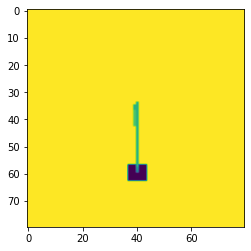

In [ ]:
import cv2
import torchvision.transforms

## We take an image from the environment
testImage = torch.Tensor([env.render(mode = 'rgb_array')]).to(device)
testImage = torch.transpose(torch.transpose(testImage, 1,3), 2,3)
testImage = torchvision.transforms.Grayscale().to(device).forward(testImage)
testImage = torchvision.transforms.Resize((80,80)).to(device).forward(testImage)
print(testImage.shape)


## We need four frames in order to understand which movement
testImage = torch.cat((testImage, testImage), dim = 1).to(device)
testImage = torch.cat((testImage, testImage), dim = 1).to(device)

print(testImage.shape)
action = testNetwork(testImage)
print(action)
action = np.argmax(action.detach().cpu().numpy())
print(action)

plt.figure()
plt.imshow(testImage.detach().cpu().numpy().squeeze()[0])


We define a transforms.Compose for each image obtained from the environment

In [ ]:
transf = torchvision.transforms.Compose(
    [     
     torchvision.transforms.Grayscale().to(device),
     torchvision.transforms.Resize((80,80)).to(device),
    ]
)

testImage = torch.Tensor([env.render(mode = 'rgb_array')]).to(device)
testImage = torch.transpose(torch.transpose(testImage, 1,3), 2,3)
testImage = transf(testImage)
print(testImage.shape)

torch.Size([1, 1, 80, 80])


We want to explorate different exploration rate. We are going to use a sinusoidal dynamics.

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

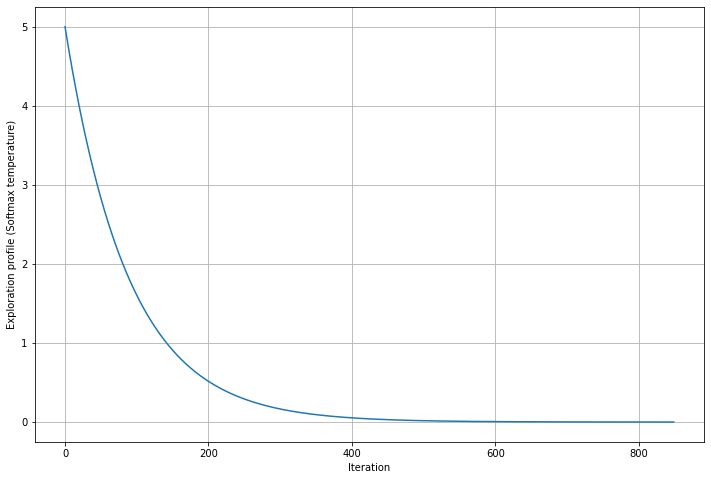

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 850
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]



### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(np.abs(exploration_profile))
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

Now we have to define our training loop for the CNN part

This is the updateStep function

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
def update_step_CNN(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    
    states      = torch.cat([s[0] for s in batch]).to(device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.cat([s[2] for s in batch if s[2] is not None]).to(device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)
    


    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)

    target_net.train()
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values).to(device)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

Main Training LOOP

In [ ]:
class StateContainer(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state):
        self.memory.append( state ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return [self.memory[i] for i in range(batch_size)]
        
    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
learning_rate = 0.01

## Number of batches
batch_size = 256
## Gamma value
gamma = 0.999
## bad state penalty value
bad_state_penalty = 6
## net_update_steps value
net_update_steps = 10
# Capacity of the replay memory
replay_memory_capacity = 10000


### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity) 

### Initialize the policy network
policy_net = DQNCNN().to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQNCNN().to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=learning_rate) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function 
loss_fn = nn.SmoothL1Loss().to(device)

### Initialize the state container which can be seen as a replayMemory
containerState = StateContainer(4)

min_samples_for_training = 1000
target_net_update_steps = 25

In [ ]:
def choose_action_epsilon_greedyCNN(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action   
    return action, net_out.cpu().numpy()

In [ ]:
def choose_action_softmax_CNN(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedyCNN(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        net_out = net(state)
        net_out = torch.reshape( net_out, (-1,) );
    
    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.detach().cpu() / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.detach().cpu().numpy()

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
episodeScore = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    state = torch.Tensor([env.render(mode = 'rgb_array')]).to(device)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # We have first to elaborate the initial state
    state = torch.transpose(torch.transpose(state, 1,3), 2,3)
    state = transf(state)
    for i in range(4):
      containerState.push(state)
    state = torch.cat(containerState.sample(4), dim = 1).to(device)

    # Go on until the pole falls off - (foreach frame)
    while not done and score < 490:    

      action, q_values = choose_action_softmax_CNN(policy_net, state, temperature = tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      _, reward, done, _ = env.step(action)

      next_state = torch.Tensor([env.render(mode = 'rgb_array')]).to(device)
      next_state = torch.transpose(torch.transpose(next_state, 1,3), 2,3)
      next_state = transf(next_state)
      containerState.push(next_state)
      next_state = torch.cat(containerState.sample(4), dim = 1).to(device)
      # Update the final score (+1 for each step)
      score += 1


      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step_CNN(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      state = next_state
      score += reward

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score}") # Print the final score
    episodeScore.append(score)

    done = True
env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 44.0
EPISODE: 2 - FINAL SCORE: 42.0
EPISODE: 3 - FINAL SCORE: 54.0
EPISODE: 4 - FINAL SCORE: 34.0
EPISODE: 5 - FINAL SCORE: 72.0
EPISODE: 6 - FINAL SCORE: 32.0
EPISODE: 7 - FINAL SCORE: 28.0
EPISODE: 8 - FINAL SCORE: 32.0
EPISODE: 9 - FINAL SCORE: 26.0
EPISODE: 10 - FINAL SCORE: 36.0
EPISODE: 11 - FINAL SCORE: 42.0
EPISODE: 12 - FINAL SCORE: 40.0
EPISODE: 13 - FINAL SCORE: 36.0
EPISODE: 14 - FINAL SCORE: 36.0
EPISODE: 15 - FINAL SCORE: 30.0
EPISODE: 16 - FINAL SCORE: 42.0
EPISODE: 17 - FINAL SCORE: 34.0
EPISODE: 18 - FINAL SCORE: 34.0
EPISODE: 19 - FINAL SCORE: 40.0
EPISODE: 20 - FINAL SCORE: 38.0
EPISODE: 21 - FINAL SCORE: 48.0
EPISODE: 22 - FINAL SCORE: 34.0
EPISODE: 23 - FINAL SCORE: 84.0
EPISODE: 24 - FINAL SCORE: 60.0
EPISODE: 25 - FINAL SCORE: 38.0
Updating target network...
EPISODE: 26 - FINAL SCORE: 30.0
EPISODE: 27 - FINAL SCORE: 34.0
EPISODE: 28 - FINAL SCORE: 32.0
EPISODE: 29 - FINAL SCORE: 34.0
EPISODE: 30 - FINAL SCORE: 

Text(0, 0.5, 'Score')

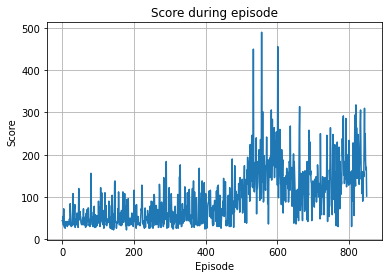

In [ ]:
plt.figure()
plt.plot(episodeScore)
plt.grid(True)
plt.title("Score during episode")
plt.xlabel("Episode")
plt.ylabel("Score")

TEST

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1')
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    state = torch.Tensor([env.render(mode = 'rgb_array')]).to(device)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # We have first to elaborate the initial state
    state = torch.transpose(torch.transpose(state, 1,3), 2,3)
    state = transf(state)
    for i in range(4):
      containerState.push(state)
    state = torch.cat(containerState.sample(4), dim = 1).to(device)
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax_CNN(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      next_state = torch.Tensor([env.render(mode = 'rgb_array')]).to(device)
      next_state = torch.transpose(torch.transpose(next_state, 1,3), 2,3)
      next_state = transf(next_state)
      containerState.push(next_state)
      next_state = torch.cat(containerState.sample(4), dim = 1).to(device)
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 74.0
EPISODE 2 - FINAL SCORE: 14.0
EPISODE 3 - FINAL SCORE: 69.0
EPISODE 4 - FINAL SCORE: 120.0
EPISODE 5 - FINAL SCORE: 128.0
EPISODE 6 - FINAL SCORE: 78.0
EPISODE 7 - FINAL SCORE: 129.0
EPISODE 8 - FINAL SCORE: 124.0
EPISODE 9 - FINAL SCORE: 98.0
EPISODE 10 - FINAL SCORE: 77.0


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.3.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000009.mp4


# MountainCar-v0 
Now we want to learn how to win the MountainCar-v0 game of Gym environment

In [ ]:
!pip install gym
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory








In [ ]:

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:15 htt

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

We define the gym environment

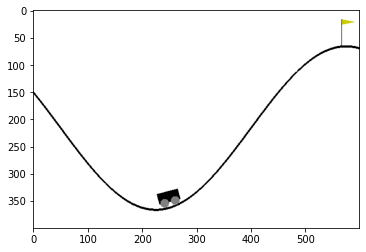

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

env.reset()
screenGame = env.render(mode = 'rgb_array')

# Thank to this tool we can see screen of the env
plt.figure()
plt.imshow(screenGame) 
plt.show()

# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

We have a state space $(x,v)$ where $x$ is the position of the car and $v$ is its velocity. we win if we reach the flag at $x = 0.5$.

Action space is discrete

*   $0$ accelerate to the left
*   $1$ do nothing
*   $2$ accelerate to the right

so our DQN is defined as follow



In [ ]:
net = DQN(state_space_dim=state_space_dim, action_space_dim=action_space_dim).to(device)

Now we have the same loop for the first task

First we use the same exploration profile as the second task

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

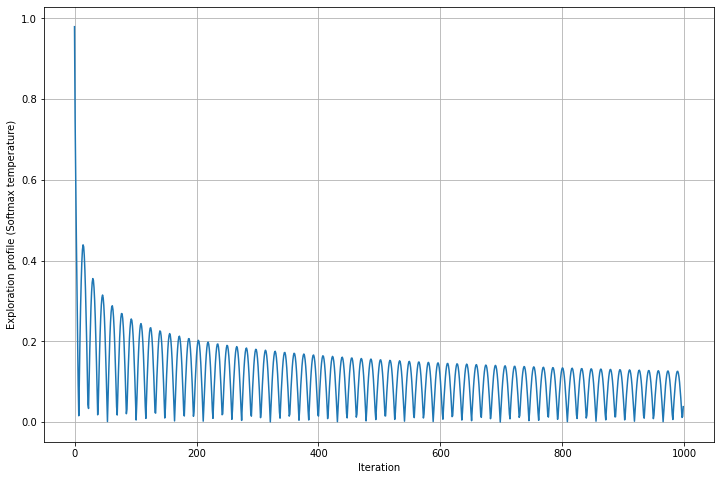

In [ ]:
### Define exploration profile
initial_value = 0.999
num_iterations = 1000
exploration_profile =np.array([initial_value * np.cos(0.2*i)/np.power(i,0.3) for i in range(1,num_iterations)])
exploration_profile[exploration_profile == 0] = 0.01
exploration_profile = np.abs(exploration_profile)


### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(np.abs(exploration_profile))
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2 # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
good_state_reward = 10 # Increase reward when its position is different from the previous one
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network


### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()


### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
episodeScore = []
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 50 == 0) # Save a video every 100 episodes
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off - (foreach frame)
    while not done and score < 490:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Avoid being in a fixed position
      reward = np.abs(next_state[0] - state[0])*good_state_reward
      if (next_state[0] >= 0.5):
        reward += 200

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()
      score = score + reward

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    episodeScore.append(score)

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 14.803825749147602 - Temperature: 0.9790865112634004
EPISODE: 2 - FINAL SCORE: 10.807253094963283 - Temperature: 0.7473858655695306
EPISODE: 3 - FINAL SCORE: 14.644905123964026 - Temperature: 0.5930068335525313
EPISODE: 4 - FINAL SCORE: 6.84820870077052 - Temperature: 0.45919535222883207
EPISODE: 5 - FINAL SCORE: 8.309504742122405 - Temperature: 0.3330514340075201
Updating target network...
EPISODE: 6 - FINAL SCORE: 7.337935268037545 - Temperature: 0.21147433735457227
EPISODE: 7 - FINAL SCORE: 15.303351343091693 - Temperature: 0.09471113700267156
EPISODE: 8 - FINAL SCORE: 21.278742594711034 - Temperature: 0.015631988924068384
EPISODE: 9 - FINAL SCORE: 13.214661291088444 - Temperature: 0.11740999415624397
EPISODE: 10 - FINAL SCORE: 11.33506393182566 - Temperature: 0.20835891431001116
Updating target network...
EPISODE: 11 - FINAL SCORE: 7.047563874585728 - Temperature: 0.2863485408114631
EPISODE: 12 - FINAL SCORE: 14.467090058727688 -

In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000050.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000100.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000150.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000200.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000250.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000300.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000350.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000400.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000450.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000500.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000550.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000600.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000650.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000700.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000750.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000800.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000850.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000900.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000950.mp4


Text(0, 0.5, 'Score')

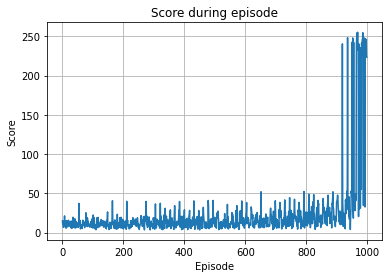

In [ ]:
plt.figure()
plt.plot(episodeScore)
plt.grid(True)
plt.title("Score during episode")
plt.xlabel("Episode")
plt.ylabel("Score")

TEST

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -150.0
EPISODE 2 - FINAL SCORE: -163.0
EPISODE 3 - FINAL SCORE: -124.0
EPISODE 4 - FINAL SCORE: -124.0
EPISODE 5 - FINAL SCORE: -150.0
EPISODE 6 - FINAL SCORE: -119.0
EPISODE 7 - FINAL SCORE: -121.0
EPISODE 8 - FINAL SCORE: -163.0
EPISODE 9 - FINAL SCORE: -155.0
EPISODE 10 - FINAL SCORE: -167.0


In [ ]:
show_videos()


SHOWING VIDEO video/openaigym.video.3.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.60.video000009.mp4
